<a href="https://colab.research.google.com/github/dylstuart/streaming_asr/blob/main/asr_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Online ASR with Emformer RNN-T

**Author**: [Jeff Hwang](jeffhwang@meta.com)_, [Moto Hira](moto@meta.com)_

This tutorial shows how to use Emformer RNN-T and streaming API
to perform online speech recognition.


<div class="alert alert-info"><h4>Note</h4><p>This tutorial requires FFmpeg libraries and SentencePiece.

   Please refer to `Optional Dependencies <optional_dependencies>`
   for the detail.</p></div>




## 1. Overview

Performing online speech recognition is composed of the following steps

1. Build the inference pipeline
   Emformer RNN-T is composed of three components: feature extractor,
   decoder and token processor.
2. Format the waveform into chunks of expected sizes.
3. Pass data through the pipeline.



In [ ]:
!pip install torchaudio==2.8.0

## 2. Preparation




In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

import IPython
import matplotlib.pyplot as plt
from torchaudio.io import StreamReader

2.8.0+cu128
2.8.0+cu128


## 3. Construct the pipeline

Pre-trained model weights and related pipeline components are
bundled as :py:class:`torchaudio.pipelines.RNNTBundle`.

We use :py:data:`torchaudio.pipelines.EMFORMER_RNNT_BASE_LIBRISPEECH`,
which is a Emformer RNN-T model trained on LibriSpeech dataset.




In [2]:
bundle = torchaudio.pipelines.EMFORMER_RNNT_BASE_LIBRISPEECH

feature_extractor = bundle.get_streaming_feature_extractor()
decoder = bundle.get_decoder()
token_processor = bundle.get_token_processor()

/usr/local/lib/python3.12/dist-packages/torchaudio/pipelines/rnnt_pipeline.py:335: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  local_path = torchaudio.utils.download_asset(self._global_stats_path)
/usr/local/lib/python3.12/dist-packages/torchaudio/pipelines/rnnt_pipeline.py:247: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  path = torchaudio.utils.download_asset(self._rnnt_path)
/usr/local/lib/python3.12/dist-packages/torchaudio/pipelines/rnnt_pipeline.py:353: UserWarning: torcha

Streaming inference works on input data with overlap.
Emformer RNN-T model treats the newest portion of the input data
as the "right context" — a preview of future context.
In each inference call, the model expects the main segment
to start from this right context from the previous inference call.
The following figure illustrates this.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/emformer_rnnt_context.png">

The size of main segment and right context, along with
the expected sample rate can be retrieved from bundle.




In [3]:
sample_rate = bundle.sample_rate
segment_length = bundle.segment_length * bundle.hop_length
context_length = bundle.right_context_length * bundle.hop_length

print(f"Sample rate: {sample_rate}")
print(f"Main segment: {segment_length} frames ({segment_length / sample_rate} seconds)")
print(f"Right context: {context_length} frames ({context_length / sample_rate} seconds)")

Sample rate: 16000
Main segment: 2560 frames (0.16 seconds)
Right context: 640 frames (0.04 seconds)


## 4. Configure the audio stream

Next, we configure the input audio stream using :py:class:`torchaudio.io.StreamReader`.

For the detail of this API, please refer to the
[StreamReader Basic Usage](./streamreader_basic_tutorial.html)_.




The following audio file was originally published by LibriVox project,
and it is in the public domain.

https://librivox.org/great-pirate-stories-by-joseph-lewis-french/

It was re-uploaded for the sake of the tutorial.




In [4]:
src = "https://download.pytorch.org/torchaudio/tutorial-assets/greatpiratestories_00_various.mp3"

streamer = StreamReader(src)
streamer.add_basic_audio_stream(frames_per_chunk=segment_length, sample_rate=bundle.sample_rate)

print(streamer.get_src_stream_info(0))
print(streamer.get_out_stream_info(0))

SourceAudioStream(media_type='audio', codec='mp3', codec_long_name='MP3 (MPEG audio layer 3)', format='fltp', bit_rate=128000, num_frames=0, bits_per_sample=0, metadata={}, sample_rate=44100.0, num_channels=2)
OutputAudioStream(source_index=0, filter_description='aresample=16000,aformat=sample_fmts=fltp', media_type='audio', format='fltp', sample_rate=16000.0, num_channels=2)


/tmp/ipython-input-2138279009.py:3: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  streamer = StreamReader(src)


As previously explained, Emformer RNN-T model expects input data with
overlaps; however, `Streamer` iterates the source media without overlap,
so we make a helper structure that caches a part of input data from
`Streamer` as right context and then appends it to the next input data from
`Streamer`.

The following figure illustrates this.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/emformer_rnnt_streamer_context.png">




In [5]:
class ContextCacher:
    """Cache the end of input data and prepend the next input data with it.

    Args:
        segment_length (int): The size of main segment.
            If the incoming segment is shorter, then the segment is padded.
        context_length (int): The size of the context, cached and appended.
    """

    def __init__(self, segment_length: int, context_length: int):
        self.segment_length = segment_length
        self.context_length = context_length
        self.context = torch.zeros([context_length])

    def __call__(self, chunk: torch.Tensor):
        if chunk.size(0) < self.segment_length:
            chunk = torch.nn.functional.pad(chunk, (0, self.segment_length - chunk.size(0)))
        chunk_with_context = torch.cat((self.context, chunk))
        self.context = chunk[-self.context_length :]
        return chunk_with_context

## 5. Run stream inference

Finally, we run the recognition.

First, we initialize the stream iterator, context cacher, and
state and hypothesis that are used by decoder to carry over the
decoding state between inference calls.




In [6]:
cacher = ContextCacher(segment_length, context_length)

state, hypothesis = None, None

Next we, run the inference.

For the sake of better display, we create a helper function which
processes the source stream up to the given times and call it
repeatedly.




In [7]:
stream_iterator = streamer.stream()


def _plot(feats, num_iter, unit=25):
    unit_dur = segment_length / sample_rate * unit
    num_plots = num_iter // unit + (1 if num_iter % unit else 0)
    fig, axes = plt.subplots(num_plots, 1)
    t0 = 0
    for i, ax in enumerate(axes):
        feats_ = feats[i * unit : (i + 1) * unit]
        t1 = t0 + segment_length / sample_rate * len(feats_)
        feats_ = torch.cat([f[2:-2] for f in feats_])  # remove boundary effect and overlap
        ax.imshow(feats_.T, extent=[t0, t1, 0, 1], aspect="auto", origin="lower")
        ax.tick_params(which="both", left=False, labelleft=False)
        ax.set_xlim(t0, t0 + unit_dur)
        t0 = t1
    fig.suptitle("MelSpectrogram Feature")
    plt.tight_layout()


@torch.inference_mode()
def run_inference(num_iter=100):
    global state, hypothesis
    chunks = []
    feats = []
    for i, (chunk,) in enumerate(stream_iterator, start=1):
        segment = cacher(chunk[:, 0])
        features, length = feature_extractor(segment)
        hypos, state = decoder.infer(features, length, 10, state=state, hypothesis=hypothesis)
        hypothesis = hypos
        transcript = token_processor(hypos[0][0], lstrip=False)
        print(transcript, end="\r", flush=True)
        chunks.append(chunk)
        feats.append(features)
        if i == num_iter:
            break

    # Plot the features
    _plot(feats, num_iter)
    return IPython.display.Audio(torch.cat(chunks).T.numpy(), rate=bundle.sample_rate)

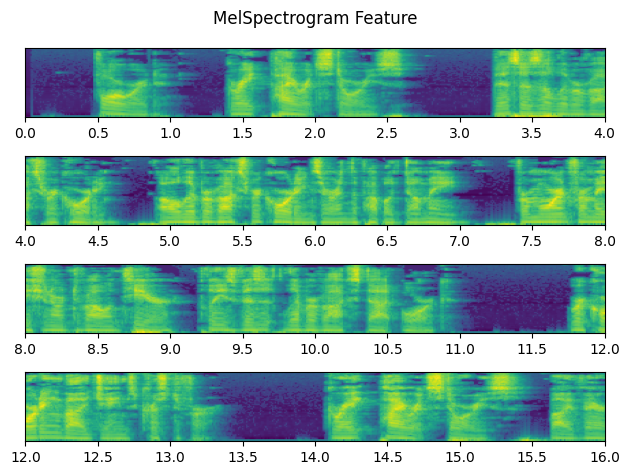

In [8]:
run_inference()

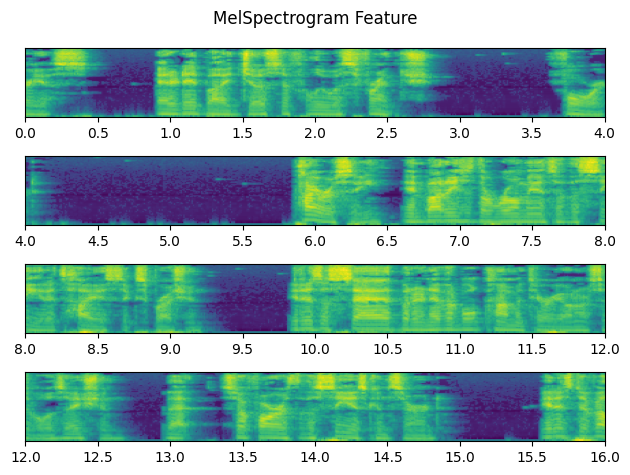

In [9]:
run_inference()

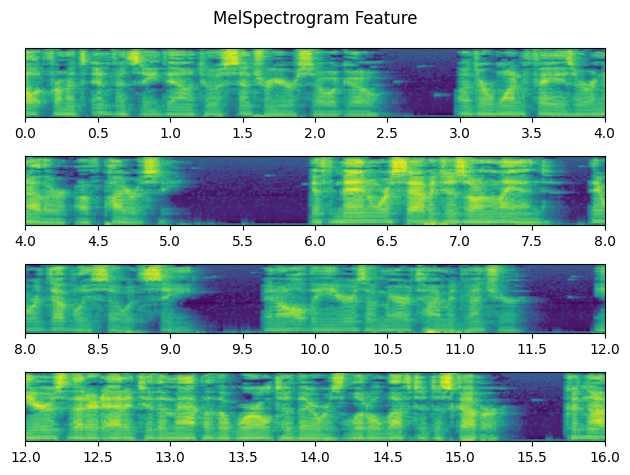

In [10]:
run_inference()

In [ ]:
run_inference()

In [ ]:
run_inference()

In [ ]:
run_inference()

In [ ]:
run_inference()

In [ ]:
run_inference()

In [ ]:
run_inference()

In [ ]:
run_inference()

In [ ]:
run_inference()

Tag: :obj:`torchaudio.io`

